### job.py

In [10]:
import gymnasium as gym
import numpy as np
import datetime
import random
from matplotlib import pyplot as plt

In [2]:
"""
Job class for basic concept:
    1.  All jobs have only one recipe.
    2.  All jobs have a deadline.
    3.  All jobs are inserted into a machine using trays.
    4.  Machines can perform at least one recipe.
    5.  Machines have a maximum tray capacity as part of their attributes. Once a machine’s tray capacity is maxed out,
        no jobs can be assigned to it.
    6.  Recipes have a duration of time to complete.
    7.  The goal of the RL agent is to minimize tardiness (having most jobs completed before or on their deadline) and
        maximize efficiency of machines (machines should not be left idle for long periods).
    8.  The observation space is the job buffer (pending jobs to be scheduled), machines and their current capacity,
        and jobs completed.
    9.  The action of RL agent to select which job, J_i to assign to machine M_m, where 0 <= i < |J| and 0 <= m < |M|.
        The action space is thus all possible combinations of (J, M) with addition of No-Op action (taken at a timestep)
"""


class Job:
    """
    Job class
    """

    def __init__(
        self,
        recipes: list[str],
        job_id: int = 0,
        quantity: int = 0,
        deadline: str = "3000/01/01",
        priority: int = 1,
    ) -> None:
        self.job_id: int = job_id  # String for now, can be numeric
        self.recipes: list[str] = recipes  # [R1, R2, R3, ...]
        self.r_pending: list[str] = recipes.copy()
        self.quantity: int = quantity
        self.deadline: str = deadline  # YYYY/MM/DD
        self.priority: int = priority  # 1=Normal, 2=Medium, 3=High
        self.status: int = 0  # 0=New, 1=In Progress, 2=Completed, 3=Cancelled?, 4=Error? (For internal use)
        self.r_in_progress: list[str] = []
        self.r_completed: list[str] = []

    def get_recipes(self) -> list[str]:
        return self.recipes

    def get_job_id(self) -> int:
        return self.job_id

    def get_quantity(self) -> int:
        return self.quantity

    def get_deadline(self) -> str:
        return self.deadline

    def get_deadline_datetime(self) -> datetime:
        return datetime.datetime.strptime(self.deadline, "%Y/%m/%d")  # %H:%M:%S')

    def get_status(self) -> int:
        return self.status  # might come in handy in the future

    def get_priority(self) -> int:
        return self.priority

    def get_priority_str(self) -> str:
        ref_table: dict = {1: "Normal", 2: "Medium", 3: "High"}
        try:
            return ref_table[self.priority]
        except KeyError:
            return f"Key '{self.priority}' is not defined!"

    def get_status_str(self) -> str:
        ref_table: dict = {
            0: "New",
            1: "In Progress",
            2: "Completed",
            3: "Cancelled",
            4: "Error",
        }
        try:
            return ref_table[self.status]
        except KeyError:
            return f"Key '{self.status}' is not defined!"

    def update_deadline(self, new_deadline) -> None:
        self.deadline = new_deadline

    def update_priority(self, new_priority) -> None:
        self.priority = new_priority

    def update_status(self, new_status) -> None:
        self.status = new_status

    # I didn't add an update recipes because it would add complexity in the future if someone can alter the recipes

    def recipe_in_progress(self, recipe) -> None:
        self.r_pending.remove(recipe)
        self.r_in_progress.append(recipe)
        self.status = 1

    def recipe_completed(self, recipe) -> None:
        self.r_completed.append(recipe)
        self.r_in_progress.remove(recipe)
        if self.r_pending == [] and self.r_in_progress == []:
            self.status = 2

    def __str__(self) -> str:
        return (
            f"Job ID: {self.job_id}"
            f"\nRecipes: {self.recipes}"
            f"\nQuantity: {self.quantity}"
            f"\nDeadline: {self.deadline}"
            f"\nPriority: {self.get_priority_str()}"
            f"\nStatus: {self.get_status_str()}"
            f"\nIn Progress: {self.r_in_progress}"
            f"\nCompleted: {100 * len(self.r_completed) / len(self.recipes)}%"
        )

    def reset(self):
        self.status = 0
        self.r_pending = self.recipes.copy()
        self.r_in_progress = []
        self.r_completed = []

### machine.py

In [3]:
"""
Machine class for basic concept:
    1.  All jobs have only one recipe.
    2.  All jobs have a deadline.
    3.  All jobs are inserted into a machine using trays.
    4.  Machines can perform at least one recipe.
    5.  Machines have a maximum tray capacity as part of their attributes. Once a machine’s tray capacity is maxed out,
        no jobs can be assigned to it.
    6.  Recipes have a duration of time to complete.
    7.  The goal of the RL agent is to minimize tardiness (having most jobs completed before or on their deadline) and
        maximize efficiency of machines (machines should not be left idle for long periods).
    8.  The observation space is the job buffer (pending jobs to be scheduled), machines and their current capacity,
        and jobs completed.
    9.  The action of RL agent to select which job, J_i to assign to machine M_m, where 0 <= i < |J| and 0 <= m < |M|.
        The action space is thus all possible combinations of (J, M) with addition of No-Op action (taken at a timestep)
"""

# from custom_environment.job import Job


class Machine:
    """
    Machine class
    """

    def __init__(
        self,
        k_recipes: list[int],
        machine_id: int = 0,
        m_type: str = "A",
        cap: int = 10_000,
    ) -> None:
        self.machine_id: int = machine_id
        self.machine_type: str = m_type  # A, B, C, D...
        self.known_recipes: list[int] = k_recipes  # R1, R2, R3...
        self.tray_capacity: int = cap
        self.status: int = 0  # 0=Free, 1=Busy - assuming you cannot open a machine that is working to add more trays
        self.active_recipe: str = ""
        self.active_jobs: list[Job] = []
        self.timestamp_current_status = datetime.datetime.now()
        self.recipe_times: dict[str, float | int] = {
            "A1": 1.0,
            "A2": 0,
        }  # minutes: hours

    def get_known_recipes(self) -> list[int]:
        return self.known_recipes

    def get_recipe_time(self, recipe):
        return self.recipe_times[recipe]

    def get_machine_id(self) -> int:
        return self.machine_id

    def get_machine_type(self) -> str:
        return self.machine_type

    def get_tray_capacity(self) -> int:
        return self.tray_capacity

    def get_status(self) -> int:
        return self.status

    def get_status_str(self) -> str:
        if self.status == 0:
            return "Free"
        else:
            return "Busy"

    def get_timestamp_status(self) -> datetime:
        return self.timestamp_current_status

    def get_active_recipe(self) -> str:
        return self.active_recipe

    def get_active_jobs(self) -> list[Job]:
        return self.active_jobs

    def update_known_recipes(self, new_recipes) -> None:
        self.known_recipes = new_recipes

    def update_tray_capacity(self, new_capacity) -> None:
        self.tray_capacity = new_capacity

    def assign_jobs(self, jobs_to_assign: list[Job]) -> bool:
        # print("Assign jobs:", jobs_to_assign)
        # find compatible recipe between jobs and machine: recipe=js[0].get_recipes()
        recipe: str = (jobs_to_assign[0].get_recipes())[0]
        # print(jobs_to_assign,recipe)
        if self.get_status() == 0:
            is_assigned: bool = self.set_active_recipe(recipe)
            if is_assigned:
                self.status = 1
                self.timestamp_current_status = datetime.datetime.now()
                for job_to_assign in jobs_to_assign:
                    self.active_jobs.append(job_to_assign)
                    job_to_assign.recipe_in_progress(recipe)
            return is_assigned
        else:
            return False  # machine is busy!

    def set_active_recipe(self, recipe) -> bool:
        if recipe in self.known_recipes:
            self.active_recipe = recipe
            return True
        return False

    def __str__(self) -> str:
        return (
            f"Type: {self.machine_type}"
            f"\nKnown Recipes: {self.known_recipes}"
            f"\nTray Capacity: {self.tray_capacity}"
            f" \nStatus: {self.get_status_str()}"
            f"\nWorking on recipe: {self.active_recipe} for the following Jobs: {[j.get_job_id() for j in self.active_jobs]}"
        )

    def reset(self):
        self.status = 0
        self.active_jobs = []
        self.active_recipe = ""

### environment.py

In [4]:
"""
Custom environment class for basic concept:
    1.  All jobs have only one recipe.
    2.  All jobs have a deadline.
    3.  All jobs are inserted into a machine using trays.
    4.  Machines can perform at least one recipe.
    5.  Machines have a maximum tray capacity as part of their attributes. Once a machine’s tray capacity is maxed out,
        no jobs can be assigned to it.
    6.  Recipes have a duration of time to complete.
    7.  The goal of the RL agent is to minimize tardiness (having most jobs completed before or on their deadline) and
        maximize efficiency of machines (machines should not be left idle for long periods).
    8.  The observation space is the job buffer (pending jobs to be scheduled), machines and their current capacity,
        and jobs completed.
    9.  The action of RL agent to select which job, J_i to assign to machine M_m, where 0 <= i < |J| and 0 <= m < |M|.
        The action space is thus all possible combinations of (J, M) with addition of No-Op action (taken at a timestep)

Base source:
    - https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html
"""

# from custom_environment.machine import Machine
# from custom_environment.job import Job

import gymnasium as gym
import numpy as np
import datetime


class FactoryEnv(gym.Env):
    """
    Custom Environment that follows gym interface
    """

    NEUTRAL_REWARD = 0
    NEGATIVE_REWARD = -1
    ILEGAL_REWARD = -10

    NO_OP_SPACE = 1
    NO_OP_ACTION = -1

    REWARD_WEIGHTS = {"Idle": -1, "Deadline": -5, "Completed": 2}

    metadata: dict = {"render_modes": ["vector"]}

    def __init__(
        self, machines: list[Machine], jobs: list[Job], max_steps: int = 10_000
    ) -> None:
        """
        FactoryEnv constructor method using gym.space objects for action and observation space

        machines: array of Machine (M) instances
        jobs: array of Job (J) instances
        pending_jobs: array of jobs pending for operation by a machine
        completed_jobs: array of jobs completed
        action_space: all possible combinations of (J, M) with addition of No-Op action (taken at a timestep)
        observation_space: dict containing arrays for pending jobs, machines and recipes and No-op, and completed jobs
        current_obs: the current observation dict taken at a time step, for when there is a no-op action
        max_steps: maximum steps for learning in the environment
        time_step: steps counter
        """
        super(FactoryEnv, self).__init__()

        self.machines: list[Machine] = machines
        self.jobs: list[Job] = jobs

        self.action_space: gym.spaces.Discrete = gym.spaces.Discrete(
            2 ** (len(self.machines) * len(self.jobs))
        )

        self.pending_jobs: list[Job] = self.jobs.copy()
        pending_jobs_space: gym.spaces.Box = gym.spaces.Box(
            low=0, high=1, shape=(len(self.jobs),), dtype=np.float64
        )

        machine_space: gym.spaces.Box = gym.spaces.Box(
            low=0,
            high=1,
            shape=(len(self.machines) * len(self.jobs),),
            dtype=np.float64,
        )

        self.completed_jobs: list[Job] = []
        jobs_completed_space: gym.spaces.Box = gym.spaces.Box(
            low=0, high=1, shape=(len(self.jobs),), dtype=np.float64
        )

        self.observation_space: gym.spaces.Dict = gym.spaces.Dict(
            {
                "pending_jobs": pending_jobs_space,
                "machines": machine_space,
                "completed_jobs": jobs_completed_space,
            }
        )
        self.current_obs: dict[str, np.ndarray[any]] = dict()

        self.max_steps: int = max_steps
        self.time_step: int = 0

    def get_obs(self) -> dict[str, np.ndarray[any]]:
        """
        return: observation dict containing binary arrays for pending jobs, machines' active jobs, and completed jobs
        """
        is_pending_jobs = np.zeros(len(self.jobs), dtype=np.float64)
        for job in self.pending_jobs:
            is_pending_jobs[job.get_job_id()] = 1.0

        is_machines_active_jobs = np.zeros(
            (len(self.machines), len(self.jobs)), dtype=np.float64
        )
        for machine in self.machines:
            for job in machine.get_active_jobs():
                is_machines_active_jobs[
                    machine.get_machine_id(), job.get_job_id()
                ] = 1.0

        is_completed_jobs = np.zeros(len(self.jobs), dtype=np.float64)
        for job in self.completed_jobs:
            is_completed_jobs[job.get_job_id()] = 1.0

        self.current_obs = {
            "pending_jobs": is_pending_jobs,
            "machines": is_machines_active_jobs.flatten(),
            "completed_jobs": is_completed_jobs,
            "achieved_goal": False,  # since it is never ending
        }
        return self.current_obs

    def translate_action_to_jobs(self, action):
        m = len(self.machines)
        j = len(self.jobs)
        machine_jobs_tuples = []
        max_len = m * j  # to fill with zeros to the left
        bin_act_str = str(bin(action).replace("0b", "")).zfill(max_len)
        matrix = np.array(list(bin_act_str), dtype=int).reshape(m, j)
        sums = np.sum(matrix, axis=0)
        # validate an job is not going to two machines at the same time
        for i in sums:
            if i > 1:
                return "I"  # really invalid action (i never want to take these)
        if sum(sums) == 0:
            return "NO_OP"  # no operation
        try:
            for machine in range(m):
                selected_jobs = []
                for job in range(j):
                    if matrix[machine][job] == 1:
                        selected_jobs.append(job)
                machine_jobs_tuples.append(
                    (machine, selected_jobs)
                )  # (machine,selected_jobs)
            return machine_jobs_tuples
        except Exception as e:
            return e

    def compute_reward(self) -> int:
        """
        Compute reward based on minimizing of tardiness and maximizing of machine efficiency
        REWARD_WEIGHTS = {"Idle":-1,"Deadline":-5,"Completed":4}
        """
        total_time_unused = 0
        total_time_deadlines = 0
        for m in self.machines:
            # compute free time
            if m.get_status() == 0:
                total_time_unused += (
                    (datetime.datetime.now() - m.get_timestamp_status()).seconds
                ) // 3600  # round- in hours
        for j in self.jobs:
            # i would say i can give partial weights depending on how past the deadline we are. 40% if < 10 hours, 80% < 24hours, 100% >24 hours
            # calculate deadlines past
            if j.get_deadline_datetime() < datetime.datetime.now():
                time_past = (
                    (datetime.datetime.now() - j.get_deadline_datetime()).seconds
                ) // 3600
                if time_past < 10:
                    total_time_deadlines += 0.4 * time_past
                elif 10 <= time_past < 24:
                    total_time_deadlines += 0.8 * time_past
                else:
                    total_time_deadlines += time_past

        completed_jobs = len(self.completed_jobs)
        #         print("Values:\nTTU:",total_time_unused,"\nTTD:",total_time_deadlines, "\nCompleted", completed_jobs)
        return int(
            self.REWARD_WEIGHTS["Idle"] * total_time_unused
            + self.REWARD_WEIGHTS["Deadline"] * total_time_deadlines
            + self.REWARD_WEIGHTS["Completed"] * completed_jobs
        )

    def get_jobs(self, ids):
        requested = []
        for j in self.jobs:
            if j.get_job_id() in ids:
                requested.append(j)
        return requested

    def check_completed_jobs(self):
        for m in self.machines:
            if m.get_status() == 1:
                time_dif = (
                    datetime.datetime.now() - m.get_timestamp_status()
                ).seconds / 3600  # in hours
                recipe_time = m.get_recipe_time(m.get_active_recipe())
                if recipe_time <= time_dif:
                    for j in m.get_active_jobs():
                        # move jobs to completed
                        self.completed_jobs.append(j)
                    m.reset()

    def step(
        self, action: np.float32
    ) -> tuple[dict[str, np.ndarray[any]], int, bool, bool, dict[str, str]]:
        """
        Take a single step in the factory environment
        :param action: the agent's action to take in the step
        :return: (observation, reward, terminated, truncated, info)
        """
        self.time_step += 1
        # TBD
        # Maybe i should check the time and update any necessary machines if their time to complete has finished, on every step
        self.check_completed_jobs()
        is_terminated: bool = self.time_step > self.max_steps

        # action_binary = bin(action)

        # Jobs to do based on action
        to_do = self.translate_action_to_jobs(action)
        # should i first get valid actions or validate the action after
        #         if action.item() == self.NO_OP_ACTION:
        #             return (
        #                 self.current_obs,
        #                 self.NEUTRAL_REWARD,
        #                 is_terminated,
        #                 False,
        #                 {"Error": "No operation"},
        #             )

        #         job_id: int = action.item(0) // len(self.machines)
        # print(to_do)
        if to_do == "I":  # legally invalid action
            return (
                self.get_obs(),  # observation
                self.ILEGAL_REWARD,  # reward
                is_terminated,  # terminated
                True,  # truncated
                {"Error": "Invalid Action"},  # info
            )

        if to_do == "NO_OP":
            return (
                self.get_obs(),  # observation
                self.NEUTRAL_REWARD,  # reward
                is_terminated,  # terminated
                True,  # truncated
                {"Error": "Invalid Action"},  # info
            )

        # job: Job = self.pending_jobs[job_id]
        # machine_id: int = action.item(0) % len(self.machines)

        try:
            for t in to_do:
                m = t[0]
                js = t[1]
                if js != []:
                    if self.machines[m].assign_jobs(jobs=self.get_jobs(js)):
                        ###################################
                        # TDB: What to do with pending jobs
                        ###################################
                        for pj in self.pending_jobs:
                            print("")
            #                         if pj.get_job_id() in js:
            #                             self.pending_jobs.remove(self.get_jobs(pj))
            # self.completed_jobs.append(job)

            return (
                self.get_obs(),
                self.compute_reward(),
                is_terminated,
                False,
                {},
            )
        except Exception as e:
            return (
                self.get_obs(),
                self.NEGATIVE_REWARD,
                is_terminated,
                True,
                {"Error": "Invalid job assignment. ", "Exception": e},
            )

    def reset(
        self, seed: int = None, options: str = None
    ) -> tuple[dict[str, np.ndarray[any]], dict[str, str]]:
        self.time_step = 0

        for machine in self.machines:
            machine.reset()

        for job in self.jobs:
            job.reset()

        self.pending_jobs = self.jobs.copy()
        self.completed_jobs = []

        return self.get_obs(), {}

    def render(self):
        for machine in self.machines:
            print(machine)
            print("/-------------------------/")
        print()
        print("********************************")
        print()
        for job in self.jobs:
            print(job)
            print("/-------------------------/")

    def close(self):
        self.reset()

In [5]:
def init_custom_factory_env(is_verbose: bool = False) -> FactoryEnv:
    """
    Create a custom FactoryEnv environment for development and testing
    :param is_verbose: print statements if True
    :return: custom FactoryEnv environment instance
    """
    # In case we want to pick them from a csv file:
    #     def pickUpJobs(self,path):
    #         jobs_df = pd.read_csv(path+"jobs.csv")
    #         for i,r in jobs_df.iterrows():
    #             r_rec = r["Recipes"].replace("'","")
    #             r_rec = r_rec.split(',')
    #             j = Job(jobId=r["Id"], recipes=r_rec, quantity=r["Quantity"],deadline=r["Deadline"], priority=r["Priority"])
    #             self.jobs.append(j)

    #     def pickUpMachines(self,path):
    #         machines_df = pd.read_csv(path+"machines.csv")
    #         for i,m in machines_df.iterrows():
    #             m_rec = m["Recipes"].replace("'","")
    #             m_rec = m_rec.split(',')
    #             m = Machine(m_type=m["Type"], k_recipes=m_rec, cap=m["Capacity"])
    #             self.machines.append(m)

    machine_one: Machine = Machine(
        k_recipes=["A1", "A2"], machine_id=0, m_type="A", cap=10_000
    )
    machine_two: Machine = Machine(
        k_recipes=["A1", "A2"], machine_id=1, m_type="A", cap=10_000
    )
    machine_three: Machine = Machine(
        k_recipes=["A2"], machine_id=2, m_type="A", cap=10_000
    )

    if is_verbose:
        print(machine_one)
        print(machine_two)
        print(machine_three)
        print()

    job_one: Job = Job(
        recipes=["A1", "A2"],
        job_id=0,
        quantity=3,
        deadline="2024/01/04",
        priority=1,
    )
    job_two: Job = Job(
        recipes=["A2", "A3"],
        job_id=1,
        quantity=10,
        deadline="2023/10/28",
        priority=2,
    )
    job_three: Job = Job(
        recipes=["A3"], job_id=2, quantity=5, deadline="2023/12/04", priority=3
    )

    if is_verbose:
        job_one.recipe_in_progress("A1")
        job_one.recipe_completed("A1")

        print(job_one)
        print("/--------/")
        print(job_two)
        print("/--------/")
        print(job_three)

        job_one.reset()

    factory_env: FactoryEnv = FactoryEnv(
        machines=[machine_one, machine_two, machine_three],
        jobs=[job_one, job_two, job_three],
    )
    return factory_env

## Random Agent Test

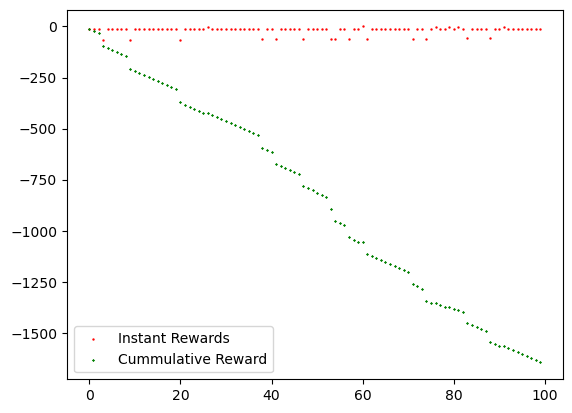

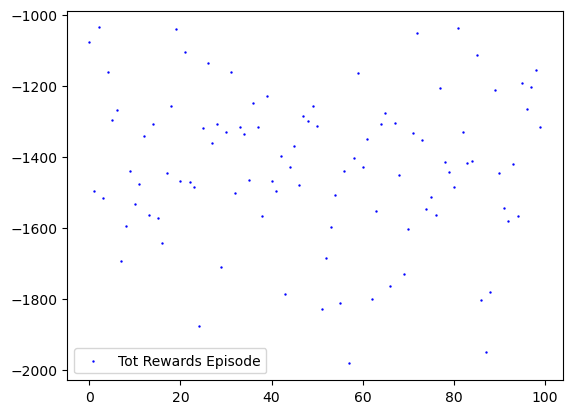

In [20]:
machines = 3
jobs = 3
max_steps = 100

j = 0
tot_reward = 0

env = init_custom_factory_env(is_verbose=False)
nr_pending_jobs = sum(env.get_obs()["pending_jobs"])

r_values = []
tr_values = []
steps = []
while j < max_steps and nr_pending_jobs > 0:
    action = random.randint(0, 2 ** ((machines * jobs) - 1))
    o, r, te, tr, i = env.step(action)
    tot_reward += r
    r_values.append(r)
    tr_values.append(tot_reward)
    steps.append(j)
    j += 1

plt.scatter(steps, r_values, c="r", marker="o", s=0.5, label="Instant Rewards")
plt.scatter(steps, tr_values, c="g", marker="x", s=0.5, label="Cummulative Reward")
plt.legend()
plt.show()

tr_values = []
episodes = 100
for e in range(episodes):
    j = 0
    env = init_custom_factory_env(is_verbose=False)
    tot_reward = 0
    while j < max_steps and nr_pending_jobs > 0:
        action = random.randint(0, 2 ** ((machines * jobs) - 1))
        o, r, te, tr, i = env.step(action)
        tot_reward += r
        j += 1
    tr_values.append(tot_reward)

plt.scatter(
    range(episodes), tr_values, c="b", marker="o", s=0.5, label="Tot Rewards Episode"
)
plt.legend()
plt.show()

### agent.py

In [135]:
"""
DQN agent class for basic concept:
    1.  All jobs have only one recipe.
    2.  All jobs have a deadline.
    3.  All jobs are inserted into a machine using trays.
    4.  Machines can perform at least one recipe.
    5.  Machines have a maximum tray capacity as part of their attributes. Once a machine’s tray capacity is maxed out,
        no jobs can be assigned to it.
    6.  Recipes have a duration of time to complete.
    7.  The goal of the RL agent is to minimize tardiness (having most jobs completed before or on their deadline) and
        maximize efficiency of machines (machines should not be left idle for long periods).
    8.  The observation space is the job buffer (pending jobs to be scheduled), machines and their current capacity,
        and jobs completed.
    9.  The action of RL agent to select which job, J_i to assign to machine M_m, where 0 <= i < |J| and 0 <= m < |M|.
        The action space is thus all possible combinations of (J, M) with addition of No-Op action (taken at a timestep)
"""

# from custom_environment.environment import FactoryEnv, init_custom_factory_env
from stable_baselines3 import DQN


class Agent:
    """
    DQN agent for learning the custom FactoryEnv environment
    """

    FILE_NAME = "dqn_custom_factory_env"
    POLICY = (
        "MultiInputPolicy"  # converts multiple Dictionary inputs into a single vector
    )
    IS_VERBOSE = 1

    def __init__(self, custom_env: FactoryEnv):
        self.custom_env = custom_env
        self.model: DQN = DQN(
            policy=self.POLICY, env=self.custom_env, verbose=self.IS_VERBOSE
        )

    def learn(self, total_time_steps: int = 10_000, log_interval: int = 4):
        self.model.learn(total_timesteps=total_time_steps, log_interval=log_interval)

    def save(self, file_name: str = FILE_NAME):
        self.model.save(file_name)

    def load(self, file_name: str = FILE_NAME):
        self.model = DQN.load(file_name)

    def evaluate(self):
        obs, info = self.custom_env.reset()
        save

        while True:
            action, _states = self.model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = self.custom_env.step(action)

            if terminated or truncated:
                print(obs)
                print(reward)
                obs, info = self.custom_env.reset()


# if __name__ == "__main__":
#     agent = Agent(custom_env=init_custom_factory_env())
#     agent.learn()
#     agent.save()

#     agent.load()
#     agent.evaluate()

In [136]:
from stable_baselines3.common.callbacks import BaseCallback


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """

    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose >= 1:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose >= 1:
                        print(f"Saving new best model to {self.save_path}")
                    self.model.save(self.save_path)
        return True

In [ ]:
import os
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results

# from custom_environment.environment import FactoryEnv, init_custom_factory_env

# Create log dir
log_dir = "./log/"
os.makedirs(log_dir, exist_ok=True)

env = init_custom_factory_env()
env = Monitor(env, log_dir)

agent = Agent(custom_env=env)
callback = SaveOnBestTrainingRewardCallback(check_freq=10, log_dir=log_dir)
agent.learn(total_time_steps=100, log_interval=5)

plot_results([log_dir], 100, results_plotter.X_TIMESTEPS, "Env v1")
plt.show()

Using cpu device
Wrapping the env in a DummyVecEnv.
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []



Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []






Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Busy
Working on recipe: A1 for the following Jobs: [0]
Type

Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Wor

Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Wor

Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Wor

Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A1', 'A2']
Tray Capacity: 10000 
Status: Free
Working on recipe:  for the following Jobs: []
Type: A
Known Recipes: ['A2']
Tray Capacity: 10000 
Status: Free
Wor

## Job Creation Code

In [5]:
import numpy as np
import time
import random
from datetime import date
import datetime


def create_job(prio):
    jobId = random.randint(0, 10000)
    r = []
    r.append(random.choice(["R1", "R2"]))
    q = random.randint(1, 10)
    dl = date.today() + datetime.timedelta(days=random.randint(0, 90))
    j = Job(job_id=jobId, recipes=r, quantity=q, deadline=dl, priority=prio)
    return j


# Parameters for the Poisson distribution
lambda_normal = 3  # Per day
lambda_high = 1  # Per day
jobs = []
seed = int(datetime.datetime.now().strftime("%d%m%Y%H%M%S"))
random.seed(seed)

# Generate a random number of incoming clients following a Poisson distribution
incoming_normal = np.random.poisson(lambda_normal)
for i in range(incoming_normal):
    jobs.append(create_job(prio=1))
incoming_high = np.random.poisson(lambda_high)
for i in range(incoming_normal):
    jobs.append(create_job(prio=3))

print("Jobs:")
for j in jobs:
    print(j)
    print("-------")

Jobs:
Job ID: 5492
Recipes: ['R1']
Quantity: 9
Deadline: 2024-01-18
Priority: Normal
Status: New
In Progress: []
Completed: 0.0%
-------
Job ID: 9243
Recipes: ['R1']
Quantity: 1
Deadline: 2023-12-13
Priority: High
Status: New
In Progress: []
Completed: 0.0%
-------


## Other code for testing things

In [134]:
import pandas as pd

# Sample data with multiple categories for each observation
data = {"ID": [1, 2, 3], "Category": [["A", "B"], ["B", "C"], ["A", "C", "D"]]}

df = pd.DataFrame(data)

# Apply dummy encoding
df_encoded = (
    pd.get_dummies(df["Category"].apply(pd.Series).stack()).groupby(level=0).sum()
)

# Concatenate the original dataframe with the encoded categories
df_final = pd.concat([df, df_encoded], axis=1).drop("Category", axis=1)

print(df_final)

   ID  A  B  C  D
0   1  1  1  0  0
1   2  0  1  1  0
2   3  1  0  1  1


In [6]:
import numpy as np

a = np.array([0, 1, 1])
a.sum()

2

In [48]:
import numpy as np

# Assuming you have an array
my_array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

# Element to find
element_to_find = 15

# Find the index or indices of the element in the array
indices = np.where(my_array == element_to_find)

if len(indices[0]) > 0:
    print(f"The element {element_to_find} is at index/indices: {indices}")
else:
    print(f"The element {element_to_find} is not in the array.")

The element 15 is not in the array.


In [ ]:
custom_factory_env = init_custom_factory_env(is_verbose=False)
custom_factory_env.step(2)
custom_factory_env.render()
custom_factory_env.step(4)